In [1]:
import numpy as np
import laserhockey.hockey_env as h_env
import gymnasium as gym
from importlib import reload
import time
import torch
import DDPG
import TD3
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

In [2]:
plt.rcParams.update({'font.size': 6})

In [3]:
np.set_printoptions(suppress=True)
reload(h_env)

C:\Users\lenna\anaconda3\envs\rl-proj\lib\site-packages\gymnasium\envs\registration.py:693: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
C:\Users\lenna\anaconda3\envs\rl-proj\lib\site-packages\gymnasium\envs\registration.py:693: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


<module 'laserhockey.hockey_env' from 'C:\\Users\\lenna\\Desktop\\RL\\Project\\RL-Hockey\\laserhockey\\hockey_env.py'>

In [4]:
### moving average to smooth out rewards ###
def moving_average(data, win_size):
    data = np.asarray(data)
    averages = []
    for i in range(len(data)-win_size):
        averages.append(np.sum(data[i:i+win_size])/win_size)
    return averages

### opponent that performs random actions
class Random_opponent():
    def __init__(self, keep_mode=True):
        self.keep_mode = keep_mode
    def act(self, obs):
        if self.keep_mode:
            return np.random.uniform(-1,1,4)
        return np.random.uniform(-1,1,3)

In [5]:
### function for saving train/test statistics
def save_statistics(type, config, rewards, net_losses, wins, losses, winrate):
    train_type = config["test"]*"test" + (1-config["test"])*"train"
    with open(f'./results/{type}_hockey_{config["name"]}_{config["mode"]}_{train_type}_stats.pkl', 'wb') as f:
        pickle.dump({"Experiment setup" : config, "Rewards": rewards, "losses": net_losses, "wins": wins, "losses":losses, "winrate": winrate}, f)

In [55]:
### training and testing ###
def train(agent1, agent2, config):
    #config.update(userconfig)
    save_as1=f'./results/{type(agent1).__name__}_hockey_{config["name"]}_{config["mode"]}_agent.pth'
    save_as2=f'./results/{type(agent2).__name__}_hockey_{config["name"]}_{config["mode"]}_agent.pth'
    if config["mode"]=="normal" or config["mode"]=="weak" or config["mode"]=="selfplay":
        env = h_env.HockeyEnv()
    elif config["mode"]=="defense":
        env = h_env.HockeyEnv(mode=h_env.HockeyEnv.TRAIN_DEFENSE)
    elif config["mode"]=="attack":
        env = h_env.HockeyEnv(mode=h_env.HockeyEnv.TRAIN_SHOOTING)
        
    if config["mode"]=="normal":
        player2 = h_env.BasicOpponent(weak=False)
    elif config["mode"]=="weak":
        player2 = h_env.BasicOpponent()
    elif config["mode"]=="defense" or config["mode"]=="attack":
        player2 = Random_opponent()
    elif config["mode"]=="selfplay":
        player2 = agent2
        
    player1 = agent1
    obs_agent2 = env.obs_agent_two()
    if type(agent1).__name__=="TD3Agent":
        train_losses = np.empty((0,4))
    else:
        train_losses = np.empty((0,2))
    rewards = []
    wins, losses, rewards = 0, 0, []
    eps = config["eps"]
    desc = "Training..."
    if config["test"]:
        desc="Testing..."
        eps = 0.0
    for i in tqdm(range(config["episodes"]), desc=desc, unit="episodes", colour="green"):
        obs, info = env.reset()
        d = False
        ep_r = 0
        old_r = 0
        while not d:
            if config["render"]:
                env.render()
            a1 = player1.act(obs, eps=config["eps"])
            a2 = player2.act(obs_agent2)
            obsnew, r, d, _, info = env.step(np.hstack([a1,a2]))
            #print(obsnew, r)
            if info['winner']==1:
                wins += 1
            elif info['winner']==-1:
                losses += 1
            player1.store_transition((obs, a1, r, obsnew, d))
            if abs(r)>0:
                player1.store_transition((obs, a1, r, obsnew, d))
                player1.store_transition((obs, a1, r, obsnew, d))
                player1.store_transition((obs, a1, r, obsnew, d))
                player1.store_transition((obs, a1, r, obsnew, d))
                player1.store_transition((obs, a1, r, obsnew, d))
            if config["mode"]=="selfplay":
                player2.store_transition((obs, a2, r, obsnew, d))
            obs_agent2 = env.obs_agent_two()
            #print(abs(obs-obsnew), abs(old_r-r))
            obs=obsnew
            ep_r +=r
            #print(r)
            old_r = r
        if not config["test"] and i>100:
            loss = player1.train(config["iter_fit"])
            train_losses = np.concatenate((train_losses, np.asarray(loss)))
            if config["mode"]=="selfplay":
                _ = player2.train(config["iter_fit"])
        rewards.append(ep_r)
    print(f'Wins: {wins}')
    print(f'Losses: {losses}')
    winrate = wins/max(1,losses)
    print(f'W/L: {winrate}')
    env.close()
    save_statistics(type(agent1).__name__, config, rewards, train_losses, wins, losses, winrate)
    if not config["test"]:
        torch.save(player1.state(), save_as1)
        if config["mode"]=="selfplay":
            torch.save(player2.state(), save_as2)       
    return train_losses, rewards

In [56]:
### initializes agents and executes training procedure ###
def init_train(config):
    env = h_env.HockeyEnv()
    agent1 = TD3.TD3Agent(env.observation_space, env.action_space, discount=config["discount"], eps=config["eps"],
                          update_target_every=config["update_target_every"], update_policy_every=config["update_policy_every"], 
                          hidden_sizes_actor=config["hidden_sizes_actor"],hidden_sizes_critic=config["hidden_sizes_critic"],
                          smoothing_std=config["smoothing_std"], smoothing_clip=config["smoothing_clip"],
                          learning_rate_actor=config["learning_rate_actor"], learning_rate_critic=config["learning_rate_critic"])
    agent2 = None
    if config["checkpoint1"]:
        agent1.restore_state(torch.load(config["checkpoint1"]))
    if config["checkpoint2"]:
        agent2.restore_state(torch.load(config["checkpoint2"]))
    env.close()    
    losses_wea, rewards_wea = train(agent1, agent2, config)
    rewards_wea_avg = moving_average(rewards_wea, 100)
    if not config["test"]:
        plt.figure(figsize=(3,2))
        plt.plot(rewards_wea_avg)
        plt.title(f'{type(agent1).__name__}_wea_{config["mode"]}')
        plt.show()
    
    '''checkpoint = f'./results/{type(agent).__name__}_hockey_{episodes}-eps{eps}-{mode}.pth' '''

        
    '''agent2 = DDPG.DDPGAgent(env.observation_space, env.action_space, 
                           discount=1, eps=eps, update_target_every=update_target_every, hidden_sizes_actor=hidden_sizes_actor,hidden_sizes_critic=hidden_sizes_critic)
    agent2.restore_state(torch.load(checkpoint2))'''

In [59]:
start_config = {
    "name" : "name",
    "agent_type" : "TD3",
    "test" : False,
    "render" : False,
    "episodes" : 10000,
    "mode" : "normal",
    "eps" : 0.1,
    "discount":1,
    "update_target_every":100,
    "update_policy_every":20,
    "hidden_sizes_actor" : [128,128],
    "hidden_sizes_critic" : [128,128,64],
    "iter_fit" : 32,
    "smoothing_std"  : 0.0005,
    "smoothing_clip" : 0.00025,
    "checkpoint1" : None,
    "checkpoint2" : None,
    "learning_rate_actor": 0.0001,
    "learning_rate_critic": 0.0001,
    "buffer_size" : 25000
}
# lr of 0.001 for both seems to work best
# large buffer size seems to be better
# eps 0.1 seems to be best
# discount 1 shows best results (winning later isn't worse than earlier?)

Training...: 100%|███████████████████████████████████████████████████████| 10000/10000 [1:44:36<00:00,  1.59episodes/s]


Wins: 2750
Losses: 1225
W/L: 2.2448979591836733


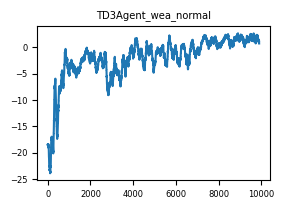

Testing...: 100%|██████████████████████████████████████████████████████████| 10000/10000 [16:36<00:00, 10.04episodes/s]


Wins: 3095
Losses: 378
W/L: 8.187830687830688


'for lr_crit in [0.001, 0.0001, 0.00001]:\n    config = start_config.copy()\n    config["name"] = "paramtest4"\n    config["mode"] = "normal"\n    print("LR CRITIC:", lr_crit)\n    config["learning_rate_critic"] = lr_crit\n    init_train(config)\n    config["checkpoint1"] = f\'./results/TD3Agent_hockey_{config["name"]}_{config["mode"]}_agent.pth\'\n    # test agent\n    config["mode"] = "normal"\n    config["test"] = True\n    init_train(config)\n    config["test"] = False'

In [60]:
### training without defense/attack ###


'''config = start_config.copy()
config["name"] = "baseline_optimparam"
config["episodes"] = 10000
config["mode"] = "normal"
init_train(config)
config["checkpoint1"] = f'./results/TD3Agent_hockey_{config["name"]}_{config["mode"]}_agent.pth'
# test agent
config["test"] = True
config["episodes"] = 5000
init_train(config)'''


config = start_config.copy()
config["name"] = "paramtest5"
config["mode"] = "normal"
init_train(config)
config["checkpoint1"] = f'./results/TD3Agent_hockey_{config["name"]}_{config["mode"]}_agent.pth'
# test agent
config["mode"] = "normal"
config["test"] = True
init_train(config)
config["test"] = False


'''for lr_crit in [0.001, 0.0001, 0.00001]:
    config = start_config.copy()
    config["name"] = "paramtest4"
    config["mode"] = "normal"
    print("LR CRITIC:", lr_crit)
    config["learning_rate_critic"] = lr_crit
    init_train(config)
    config["checkpoint1"] = f'./results/TD3Agent_hockey_{config["name"]}_{config["mode"]}_agent.pth'
    # test agent
    config["mode"] = "normal"
    config["test"] = True
    init_train(config)
    config["test"] = False'''

In [ ]:
config = start_config.copy()
config["name"] = "paramtest3"
config["test"] = True
config["render"] = True
config["episodes"] = 10
config["checkpoint1"] = f'./results/TD3Agent_hockey_{config["name"]}_{config["mode"]}_agent.pth'
init_train(config)

In [ ]:
### TRAINING CAMP ###
config = start_config.copy()
# defense training
config["name"] = "basetest"
config["mode"] = "defense"
config["episodes"] = 1000
init_train(config)
config["checkpoint1"] = f'./results/TD3Agent_hockey_{config["name"]}_{config["mode"]}_agent.pth'
# test agent trained on defense
config["mode"] = "normal"
config["test"] = True
init_train(config)

# shoot training
config["mode"] = "attack"
config["test"] = False
init_train(config)
config["checkpoint1"] = f'./results/TD3Agent_hockey_{config["name"]}_{config["mode"]}_agent.pth'
# test agent trained on defense AND shooting
config["mode"] = "normal"
config["test"] = True
init_train(config)

# regular training
config["mode"] = "normal"
config["test"] = False
init_train(config)
config["checkpoint1"] = f'./results/TD3Agent_hockey_{config["name"]}_{config["mode"]}_agent.pth'
# test agent trained on defense AND shooting
config["mode"] = "normal"
config["test"] = True
init_train(config)

Training...: 100%|█████████████████████████████████████████████████████████| 10000/10000 [47:28<00:00,  3.51episodes/s]


Wins: 1432
Losses: 798
W/L: 1.794486215538847


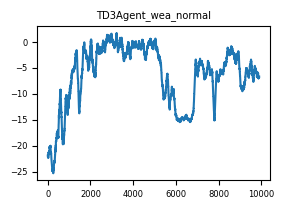

Testing...: 100%|██████████████████████████████████████████████████████████| 10000/10000 [20:26<00:00,  8.16episodes/s]


Wins: 627
Losses: 309
W/L: 2.029126213592233


In [20]:
### test 0 eps vs 0.1 ###
# test agent
config = start_config.copy()
config["name"] = "param_explore3"
config["mode"] = "normal"
#config["episodes"] = 3000
init_train(config)
config["test"] = True
config["checkpoint1"] = f'./results/TD3Agent_hockey_{config["name"]}_{config["mode"]}_agent.pth'
init_train(config)

In [9]:
test = True
render = True
episodes=10000
mode = "selfplay"
eps = 0.1
update_target_every=100
update_policy_every=20
hidden_sizes_actor = [128,128]
hidden_sizes_critic = [128,128,64]
iter_fit = 32
std  = 0.0005
c = std/2


env = h_env.HockeyEnv(mode=h_env.HockeyEnv.TRAIN_DEFENSE)
agent = TD3.TD3Agent(env.observation_space, env.action_space, discount=1, eps=eps, 
                     update_target_every=update_target_every, update_policy_every=update_policy_every, 
                     hidden_sizes_actor=hidden_sizes_actor,hidden_sizes_critic=hidden_sizes_critic,
                     smoothing_std=std, smoothing_clip=c)
checkpoint = None
if test:
    checkpoint = f'./results/{type(agent).__name__}_hockey_{episodes}-eps{eps}-{mode}.pth'
    episodes=1000
    mode='normal'
env.close()
if checkpoint is not None:
    agent.restore_state(torch.load(checkpoint))
    
#mode = "normal"
losses_wea, rewards_wea = train(agent, mode=mode, episodes=episodes, eps=eps, test=test, iter_fit=iter_fit, render=render)
rewards_wea_avg = moving_average(rewards_wea, 20)
plt.plot(rewards_wea_avg)
plt.title(f'{type(agent).__name__}_wea_{eps}')
plt.show()


TypeError: train() got an unexpected keyword argument 'mode'

In [ ]:


mode='normal'
episodes=10000
env = h_env.HockeyEnv(mode=h_env.HockeyEnv.TRAIN_DEFENSE)
agent = DDPG.DDPGAgent(env.observation_space, env.action_space, 
                       discount=1, eps=eps, update_target_every=update_target_every, hidden_sizes_actor=hidden_sizes_actor,hidden_sizes_critic=hidden_sizes_critic)
checkpoint = None
if test:
    checkpoint = f'./results/{type(agent).__name__}_hockey_{episodes}-eps{eps}-{mode}.pth'
    episodes=1000
    mode='normal'
env.close()
if checkpoint is not None:
losses_wea, rewards_wea = train(agent, mode=mode, episodes=episodes, eps=eps, test=test, iter_fit=iter_fit, render=render)
rewards_wea_avg = moving_average(rewards_wea, 20)
plt.plot(rewards_wea_avg)
plt.title(f'{type(agent).__name__}_wea_{eps}')
plt.show()


In [ ]:
A = torch.randn(5)
b = torch.clamp(A, 0.2,0.5)
print(b)

In [ ]:
episodes = 1000
eps = 0
checkpoint = f'./results/DDPG_hockey_{episodes}-eps{eps}-weak.pth'
agent = DDPG.DDPGAgent(env.observation_space, env.action_space, discount=1, eps=eps)
agent.restore_state(torch.load(checkpoint))
losses_wea,  rewards_wea = train(agent, mode="weak", episodes=1000, eps=0)

In [ ]:
rewards_weak_avg = moving_average(rewards_wea, 20)

plt.plot(rewards_weak_avg)

In [ ]:


rewards_att_avg = moving_average(rewards_att, 20)
plt.plot(rewards_def_avg.)
plt.title(f'def_{eps}')
plt.show()
plt.plot(rewards_att_avg)
plt.title(f'att_{eps}')
plt.show()

In [ ]:
rewards_def_avg = moving_average(rewards_def, 20)

In [ ]:

plt.plot(rewards_def_avg)
plt.title(f'schwanzus{eps}')